**Haley Karchmer and Richard Garcia**
# Group Assignment #3: Twitter data

### Introduction
For our workflow, we followed a specific hashtag '#affordablehousing' since our overall DH140 project is centered around the issue of affordable housinig in Los Angeles. We manipulated, visualized and analyzed the data using techniques we learned in class as well as some creative touches. To get the Twitter data, we queried it 10 times every 60 seconds and set the location to tweets from profiles within 100 km of Los Angeles.


Import tweets

In [196]:
import pandas as pd

df = pd.read_csv('tweets.csv')

# override the default so that we can see the entire text in the column
pd.set_option('display.max_colwidth', None)

# drop duplicates
df = df.drop_duplicates()

Bring in the Libraries

In [197]:
import pandas as pd
import numpy as np
import plotly.express as px
import osmnx as ox
import matplotlib.pyplot as plt

# to get tweets
import tweepy as tw

# for sentiment analysis
from textblob import TextBlob
import re

# word clouds
from wordcloud import WordCloud, STOPWORDS

twitter keys/secrets/tokens

In [198]:
consumer_key= 'FcGbrUfgX2Stb20XghFG2ragR'
consumer_secret= 'JhLa8Wg6hPhwdGTfuDxtNDginicSDndET8nqwYrsVMUOHfZUOu'
access_token= '1110627218-7YcVep11bt9lUfuHUSntV3NCXR8qAPbdlgd774O'
access_token_secret= 'dh68ssmSZHMl6sDFEGlJq1wjfhojCIzMGknCZ2ohY6wKj'

authenticate with twitter

In [199]:
auth = tw.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth, wait_on_rate_limit=True)

Creation of query method using parameters

In [200]:
# search query
hashtag = '#affordablehousing'

# The search term you want to find
q = "#affordablehousing"

# Calling the user_timeline function with our parameters
results = api.search(q)
print(results)


# how many?
max_tweets = 500
 
# Creation of query method using parameters
tweets = tw.Cursor(api.search,
                   q=q, 
                   tweet_mode='extended').items(max_tweets)

[Status(_api=<tweepy.api.API object at 0x7f76a1893d30>, _json={'created_at': 'Wed Feb 24 10:09:51 +0000 2021', 'id': 1364517891060736000, 'id_str': '1364517891060736000', 'text': "Congratulations to PIDG company @InfracoAfrica. Read about their monumental investment in Nairobi's… https://t.co/Epl8IpF5JX", 'truncated': True, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'InfracoAfrica', 'name': 'InfraCo Africa Ltd', 'id': 1577886223, 'id_str': '1577886223', 'indices': [32, 46]}], 'urls': [{'url': 'https://t.co/Epl8IpF5JX', 'expanded_url': 'https://twitter.com/i/web/status/1364517891060736000', 'display_url': 'twitter.com/i/web/status/1…', 'indices': [101, 124]}]}, 'metadata': {'iso_language_code': 'en', 'result_type': 'recent'}, 'source': '<a href="https://mobile.twitter.com" rel="nofollow">Twitter Web App</a>', 'in_reply_to_status_id': None, 'in_reply_to_status_id_str': None, 'in_reply_to_user_id': None, 'in_reply_to_user_id_str': None, 'in_reply_to_scre

In [201]:
for index, tweet in enumerate(tweets):
    print(index, tweet.full_text)

0 Congratulations to PIDG company @InfracoAfrica. Read about their monumental investment in Nairobi's #affordablehousing sector, providing affordable and purpose-built student housing. https://t.co/VTYL51ESUc
1 खुशहाल एवं सुरक्षित भविष्य का उपहार श्रीमती अनीता को हमारे प्रोजेक्ट भास्कर एन्क्लेव में प्लॉट बुक करने पर हार्दिक शुभकामनाएं।
#ShreeRamGroup #HappyHomes #Jaipur #India #Villas #LuxuryApartments #Plots #AffordableHousing #AffordableApartments #ShopsInJaipur #BhaskarEnclave https://t.co/P9qXWRnswX
2 #Property market in #Motera and surrounding areas of #Ahmedabad likely to boom because of world largest #MoteraCricketStadum
@gihedcredai @CREDAINational @BCCI @GCAMotera #realestate #affordablehousing 

https://t.co/7D7rz31U1w
3 Read about the latest catalytic investment in Nairobi's #affordablehousing sector, by our sister @PIDGorg company @InfracoAfrica!

And find out more about @InfraCoAsia's projects in the PIDG priority sector: https://t.co/bHjCTGbB7I

#sustainabledevelopment #g

Keyword and place

In [202]:
tweets = tw.Cursor(api.search,
                   q=q,
                   geocode='34.068921,-118.4473751,50km', 
                   tweet_mode='extended').items(max_tweets)

In [203]:
for index, tweet in enumerate(tweets):
    print(str(tweet.created_at) + ': ' + tweet.full_text)

2021-02-24 06:13:48: RT @HowTheWestWS: @GavinNewsom Where can we live for $600 in California Gavin? Serious question???? Residents have been terrorized by high…
2021-02-24 06:08:23: @GavinNewsom Where can we live for $600 in California Gavin? Serious question???? Residents have been terrorized by high rents and gentrification, when does it stop!!??? #affordablehousing #GavinNewsom #SantaMonica 

https://t.co/54Ofp8k2aX

https://t.co/QBt4tFhVME
2021-02-24 05:27:10: RT @HowTheWestWS: @CityLab Capitalism is a cruel game! It’s dressed up pretending to be socialism in California where residents are expecte…
2021-02-24 05:24:19: @CityLab Capitalism is a cruel game! It’s dressed up pretending to be socialism in California where residents are expected to ask the Liberals permission to build affordable housing! #SantaMonica #LosAngeles #GavinNewsom #Affordablehousing 
https://t.co/54Ofp8k2aX

https://t.co/QBt4tFhVME
2021-02-24 03:48:29: RT @HowTheWestWS: @LA2050 Tragic that a empty lot is used 

### Clean the tweets

function to clean tweets using regular expressions and add to new column

In [204]:
def clean_tweet(tweet):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet).split())

# create a new column for the clean text
df['clean_text'] = ''

# loop and add the cleaned up text to the new column
for i, row in df.iterrows():
    clean = clean_tweet(row.text)
    df.at[i,'clean_text'] = clean

## Word Cloud #affordablehousing

Put every word from every tweet into a single variable

In [205]:
all_text = ' '.join(df['clean_text'])

Append the query term to this list

In [206]:
stop_words = [hashtag] + list(STOPWORDS)

Create, display the word cloud

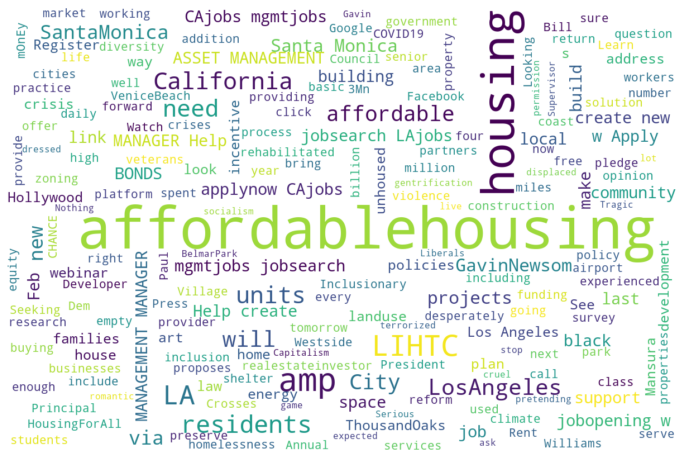

In [207]:
#Create the wordcloud
wordcloud = WordCloud(width=1200, 
                      height=800,
                      background_color="white", 
                      stopwords=stop_words).generate(all_text)
                     

# Display the WordCloud                    
plt.figure(figsize=(12,12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()    


**Even though I though I labelled the search term as a STOP word, it unfortunately still showed up on the Word Cloud. However, this visualization is useful because it shows other interesting words that appeared often among Twitter data related to affordable housing (hashtag) in LA, such as LIHTC, residents, Santa Monica, amp, job search, climate, need. This can provide insight and direction for further research on the affordable housing issue in LA.**

## Sentiment Analysis #affordablehousing


Create a new column for polarity and loop through every row, add value to new column. The polarity score ranges from -1 (most negative) to +1 (most positive). 

In [208]:
#new empty column for polarity
df['polarity']=''

In [209]:
# loop through every row and add the polarity value in our new column
for i, row in df.iterrows():
    a = TextBlob(row.clean_text)
    df.at[i,'polarity'] = a.polarity

    
df[['clean_text','polarity']].sample(5)

,clean_text,polarity
3,LA Supervisor proposes utilizing unused commercial property for affordablehousing via,0
68,15 of La Crosses 50 affordablehousing units will serve veterans who have experienced homelessness LIHTC,0.8
20,jobopening w Apply here to be a HOUSING BONDS AND ASSET MANAGEMENT MANAGER Help create new and affordablehousing projects in applynow CAjobs mgmtjobs jobsearch LAjobs,0.136364
43,Application opens February 22ndEmergencyRentalAssistance RentalAssistance SouthBay Torrance AffordableHousing Housing RentAssistance LosAngeles California,0
27,Los Angeles City Council pledges to purchase 10000 affordablehousing units by 2030 via,0


### Quantify the results. 

Tweets are either positive, neutral, or negative. Give them categorical values. Numpy has a  function `.select` that allows us to generate a categorical ranking based on conditional arguments on a given column. We can  assign tweets to be "positive" or "negative" based on their polarity values.

Create a list of our conditions and values to assign for each condition, create a new column using np.select

In [210]:
# create a list of our conditions
conditions = [
    (df['polarity'] < -0.2),# very negative
    (df['polarity'] < 0) & (df['polarity'] >= -0.2),# negative
    (df['polarity'] == 0),  # neutral
    (df['polarity'] > 0) & (df['polarity'] <= 0.2),  # positive
    (df['polarity'] > 0.2) # very positive
    ]

# create a list of the values we want to assign for each condition
values = [
    'very negative', 
    'negative', 
    'neutral', 
    'positive',
    'very positive'
]

# create a new column and use np.select to assign values to it using our lists as arguments
df['sentiment'] = np.select(conditions, values)

Display updated DataFrame that includes Sentiment column

In [211]:
df.sample(5)[['clean_text','polarity','sentiment']]

,clean_text,polarity,sentiment
62,LAST CHANCE Are you an affordablehousing provider looking for a way to conserve energy while saving money and making your tenants units more comfortable Register for our FREE webinar starting tomorrow Feb 18 Dont miss out register now,0.26,very positive
24,The City Council modified affordable housing requirements and incentives including new regulations on 100 affordable housing projects weho westhollywood housing affordablehousing ab1763 ab2345 sb330,0.136364,positive
15,Green practices like energy and waterefficiency offer the greatest benefit to lowincome families for affordablehousing says Kim Vermeer FounderPresident of Urban Habitat Initiatives and Walker Wells Principal at Raimi AssociatesRead More,0.325,very positive
58,2 factors that I believe will be important going forward I call them the Two Asrealestate realestateinvestor mortgage appraisal homeprices zillow trulia affordablehousing losangeles sanfernandovalley articles homebuying homeselling,0.4,very positive
65,Source SM daily press SantaMonica VeniceBeach AffordableHousing,0,neutral


Choose colors for charts

In [212]:
# get a 5 colors from sequential color bar
sentiment_colors = ox.plot.get_colors(5,cmap='PiYG',return_hex=True)

## Bar Chart for #affordablehousing

Plot the #affordablehousing sentiments bar chart

In [213]:
# bar chart
fig = px.bar(df, 
             x='sentiment',
             width=600,
             title='Sentiment analysis for "'+ hashtag + '"',
             color='sentiment',
             category_orders = {'sentiment':['very negative','negative','neutral','positive','very positive']},
             color_discrete_sequence=sentiment_colors, # use the colors selected in previous cell
            )
# fig.update_traces(textinfo='value')
fig.update_traces(marker_line_width=0) # gets rid of horizontal white lines
fig.show()

**This bar chart shows very clearly how the sentiment around (the hashtag) 'affordable housing' in recent public Twitter discourse in Los Angeles has been significantly very positive or positive, as opposed to being negative or very negative. This is an interesting finding because it will help inform our knowledge and research on the topic. We may also choose to include this public opinion in our final analysis.**

## Histogram for #affordablehousing

Plot the #affordablehousing sentiments as a histogram

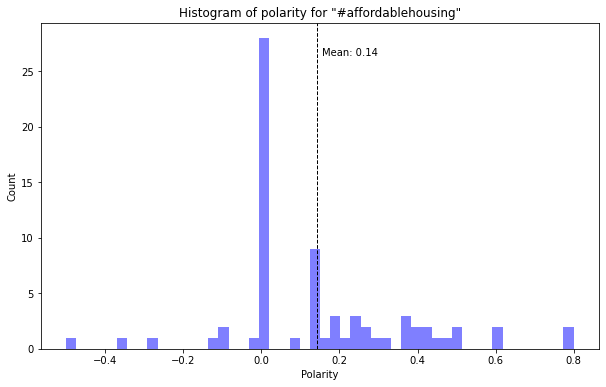

In [214]:
# histogram
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(df.polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity for "' + hashtag + '"')

plt.axvline(df.polarity.mean(), color='k', linestyle='dashed', linewidth=1)

min_ylim, max_ylim = plt.ylim()
plt.text(df.polarity.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(df.polarity.mean()))

plt.show();


**This visualization provides a different way of representing similar information as the bar chart. When looking at the histogram, there is a visible distribution in sentiments surrounding the hashtag of affordable housing. While the majority are neutral (this is generally expected), there is an overwhelming positive sentiment surrounding affordable housiing among Twitter users in LA who used the hashtag recently. Additionally, the mean is positive, which means the average sentiment is positive.**

##### Contributions
     Haley: Lead coder for thiis assignment
     Richard: Analyzed  charts and helped decide angle and workflow
